In [ ]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [ ]:
from google.colab import files
from IPython.display import Image

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
local_zip = "/content/gdrive/MyDrive/Colab Notebooks/is_it_pizza.zip"
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
pizza_images = os.listdir('/tmp/pizza_not_pizza/pizza')
not_pizza_images = os.listdir('/tmp/pizza_not_pizza/not_pizza')

In [ ]:
print(len(pizza_images))
print(len(not_pizza_images))

983
983


In [ ]:
try:
  os.mkdir("/tmp/pizza-not-pizza")
  os.mkdir("/tmp/pizza-not-pizza/training")
  os.mkdir("/tmp/pizza-not-pizza/test")
  os.mkdir("/tmp/pizza-not-pizza/training/pizza")
  os.mkdir("/tmp/pizza-not-pizza/training/not_pizza")
  os.mkdir("/tmp/pizza-not-pizza/test/pizza")
  os.mkdir("/tmp/pizza-not-pizza/test/not_pizza")
except OSError:
  pass

In [ ]:
# to avoid bias, randomly assigne images to training or testing
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


PIZZA_SOURCE_DIR = "/tmp/pizza_not_pizza/pizza/"
TRAINING_PIZZA_DIR = "/tmp/pizza-not-pizza/training/pizza/"
TEST_PIZZA_DIR = "/tmp/pizza-not-pizza/test/pizza/"
NOT_PIZZA_SOURCE_DIR = "/tmp/pizza_not_pizza/not_pizza/"
TRAINING_NOT_PIZZA_DIR = "/tmp/pizza-not-pizza/training/not_pizza/"
TEST_NOT_PIZZA_DIR = "/tmp/pizza-not-pizza/test/not_pizza/"

split_size = .9
split_data(PIZZA_SOURCE_DIR, TRAINING_PIZZA_DIR, TEST_PIZZA_DIR, split_size)
split_data(NOT_PIZZA_SOURCE_DIR, TRAINING_NOT_PIZZA_DIR, TEST_NOT_PIZZA_DIR, split_size)

In [ ]:
print(len(os.listdir('/tmp/pizza-not-pizza/training/pizza/')))
print(len(os.listdir('/tmp/pizza-not-pizza/test/pizza/')))
print(len(os.listdir('/tmp/pizza-not-pizza/training/not_pizza/')))
print(len(os.listdir('/tmp/pizza-not-pizza/test/not_pizza/')))

884
99
884
99


In [ ]:
base_model = tf.keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

In [ ]:
base_model.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=(150, 150, 3))

# scale_layer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
# x = scale_layer(inputs)

# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)


# Convert features of shape `base_model.output_shape[1:]` to vectors
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
# A Dense classifier with a single unit (binary classification)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam(),
              loss= tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
TRAINING_DIR = "/tmp/pizza-not-pizza/training"
train_datagen = ImageDataGenerator(rescale=1.0/255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip=True, vertical_flip= True)
train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    batch_size = 52,
    class_mode = 'binary',
    target_size = (150, 150))

VALIDATION_DIR = "/tmp/pizza-not-pizza/test"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    batch_size = 9,
    class_mode = 'binary',
    target_size = (150, 150))

Found 1768 images belonging to 2 classes.
Found 198 images belonging to 2 classes.


In [ ]:
earlyStop = tf.keras.callbacks.EarlyStopping(min_delta=0.01, patience=2, restore_best_weights = True)

In [ ]:
history = model.fit(train_generator, epochs = 20, steps_per_epoch = 17, 
                    validation_data = validation_generator, validation_steps = 11, callbacks = [earlyStop])

Epoch 1/20
17/17 [==============================] - 20s 567ms/step - loss: 0.5217 - binary_accuracy: 0.6878 - val_loss: 0.2543 - val_binary_accuracy: 0.9394
Epoch 2/20
17/17 [==============================] - 9s 507ms/step - loss: 0.3235 - binary_accuracy: 0.8631 - val_loss: 0.1574 - val_binary_accuracy: 0.9394
Epoch 3/20
17/17 [==============================] - 9s 501ms/step - loss: 0.2656 - binary_accuracy: 0.8744 - val_loss: 0.1361 - val_binary_accuracy: 0.9697
Epoch 4/20
17/17 [==============================] - 10s 600ms/step - loss: 0.2535 - binary_accuracy: 0.8880 - val_loss: 0.2124 - val_binary_accuracy: 0.9091
Epoch 5/20
17/17 [==============================] - 9s 538ms/step - loss: 0.2465 - binary_accuracy: 0.8959 - val_loss: 0.1776 - val_binary_accuracy: 0.8990


<Figure size 432x288 with 0 Axes>

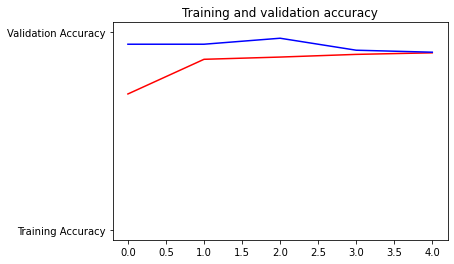

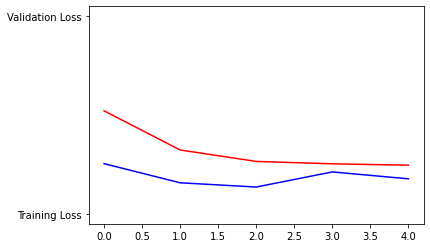

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['binary_accuracy']
val_acc=history.history['val_binary_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()


# Desired output. Charts with training and validation metrics. 

In [ ]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer= tf.keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss= tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

# Train end-to-end. Be careful to stop before you overfit!
model.fit(train_generator, epochs=10, callbacks=[earlyStop], validation_data=validation_generator, steps_per_epoch = 17, validation_steps = 11)

Epoch 1/10
17/17 [==============================] - 19s 697ms/step - loss: 0.2519 - binary_accuracy: 0.8869 - val_loss: 0.1611 - val_binary_accuracy: 0.9394
Epoch 2/10
17/17 [==============================] - 11s 628ms/step - loss: 0.2398 - binary_accuracy: 0.8869 - val_loss: 0.1558 - val_binary_accuracy: 0.9495
Epoch 3/10
17/17 [==============================] - 11s 627ms/step - loss: 0.1973 - binary_accuracy: 0.9208 - val_loss: 0.1247 - val_binary_accuracy: 0.9495
Epoch 4/10
17/17 [==============================] - 11s 620ms/step - loss: 0.1993 - binary_accuracy: 0.9163 - val_loss: 0.1573 - val_binary_accuracy: 0.9293
Epoch 5/10
17/17 [==============================] - 11s 627ms/step - loss: 0.1677 - binary_accuracy: 0.9344 - val_loss: 0.1454 - val_binary_accuracy: 0.9293


In [ ]:
# import shutil 

# shutil.rmtree('/tmp/pizza-not-pizza')